In [1]:
!pip install shap
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib

Missing values after initial data loading:
depth                 6489
psi                    115
asb_year                76
fire_hydrant_make       26
fire_hydrant_model      17
maintenance_date         0
city_section             0
hydrant_size             0
dtype: int64


Checking for missing values in features and target:
maintenance_date              0
psi                         115
depth                      6489
city_section                  0
fire_hydrant_make            26
                           ... 
fire_hydrant_model_None       0
hydrant_size_4                0
hydrant_size_5.25             0
hydrant_size_6                0
hydrant_size_8                0
Length: 198, dtype: int64
Missing values after after filling NaNs:
asb_year            76
maintenance_date     0
city_section_61      0
city_section_51      0
city_section_52      0
                    ..
city_section_28      0
city_section_29      0
city_section_30      0
city_section_300     0
hydrant_size_8       0
Le

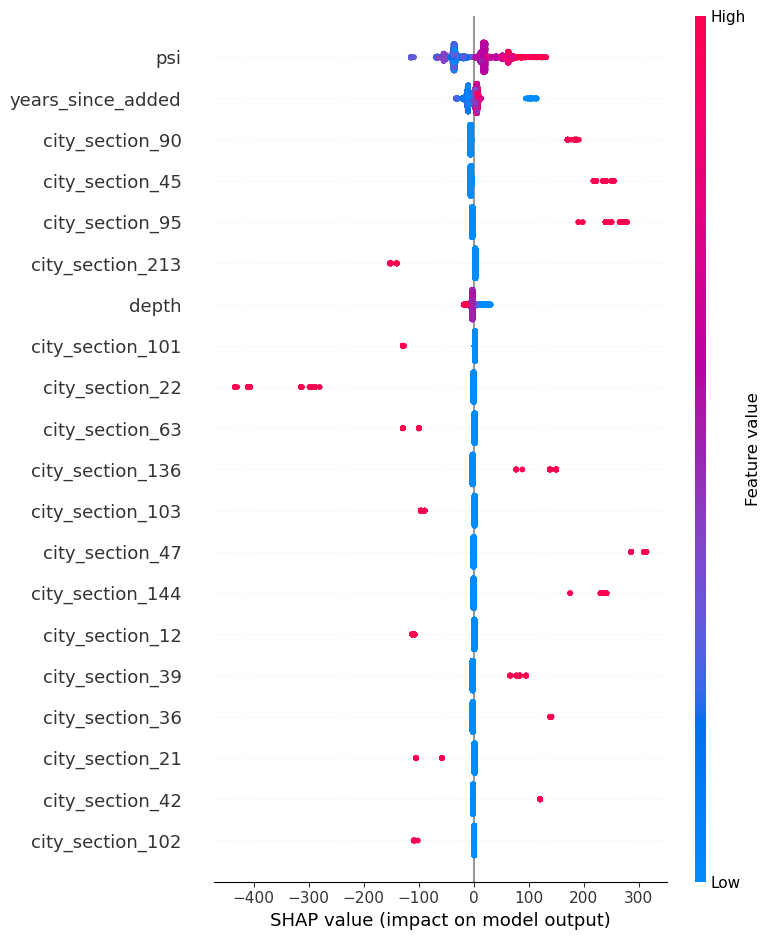

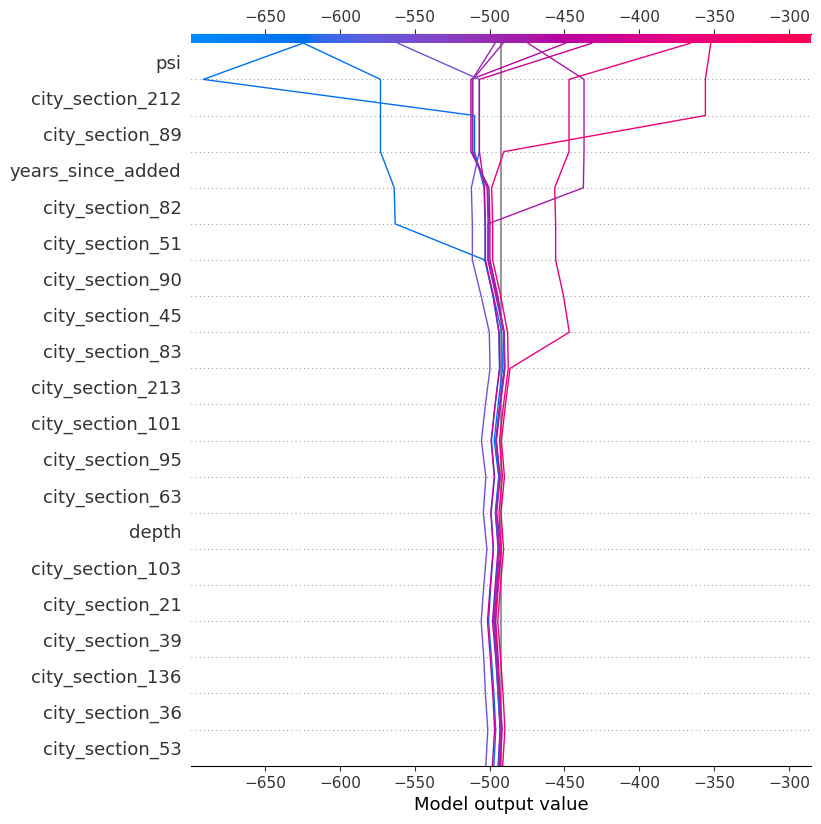

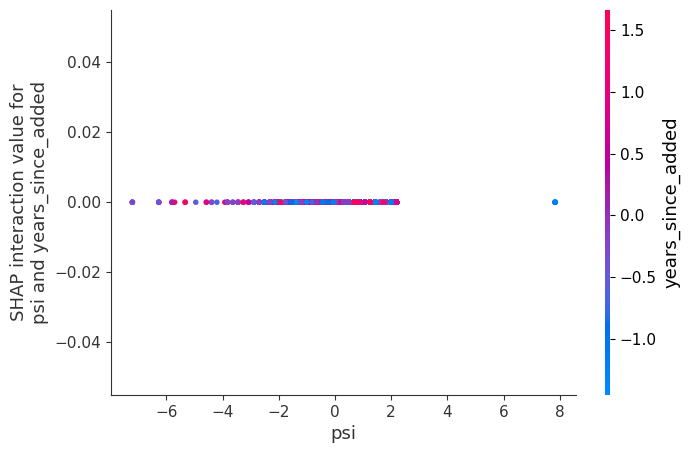

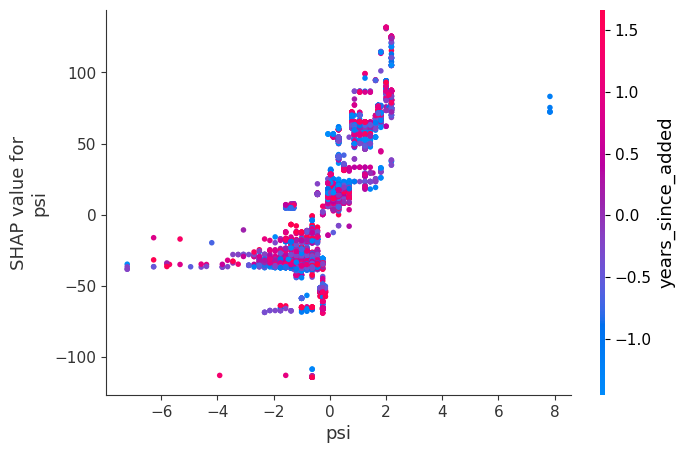

In [4]:
import json
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from datetime import timedelta
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import shap  # Import SHAP library
from sklearn.preprocessing import FunctionTransformer
from numpy import log1p
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def check_missing_values(df, step_description):
    print(f"Missing values after {step_description}:")
    # Calculate the sum of missing values per column, sort them in descending order
    missing_values_sorted = df.isnull().sum().sort_values(ascending=False)
    print(missing_values_sorted)
    print("\n")  # Adds a newline for better readability


def calculate_days_until_next_maintenance(df):
    if 'maintenance_date' in df.columns:
        basic_interval = timedelta(days=365)  # annual maintenance
        current_date = pd.Timestamp('now')
        # Ensure the result is a Series by selecting the result as a single column if necessary
        result = (df['maintenance_date'] + basic_interval - current_date).dt.days
        if isinstance(result, pd.DataFrame):
            # If result is DataFrame, convert to Series (assuming the DataFrame has only one column)
            result = result.iloc[:, 0]
        return result
    else:
        print("Error: 'maintenance_date' column not found.")
        return pd.Series()  # Return an empty Series to avoid further errors




# Load JSON data
with open('hydrant_data_mesa.json', encoding='utf-8') as file:
    data = json.load(file)

    
random.seed(50)

# Extract data from the 'data' key, which is a list of lists
hydrants = data['data']
hydrants = random.sample(hydrants, 10000)  # Randomly select 10000 hydrants

# Define the indices for each field based on your data structure
columns = {
    'maintenance_date': 35,
    'psi': 45,
    'depth': 19,
    'city_section': 14,
    'fire_hydrant_make': 23,
    'fire_hydrant_model': 24,
    'hydrant_size': 29,
    'asb_year': 11
}

# Create a DataFrame from the list of lists using the indices
df = pd.DataFrame({
    'maintenance_date': [hydrant[columns['maintenance_date']] for hydrant in hydrants],
    'psi': [hydrant[columns['psi']] for hydrant in hydrants],
    'depth': [hydrant[columns['depth']] for hydrant in hydrants],
    'city_section': [hydrant[columns['city_section']] for hydrant in hydrants],
    'fire_hydrant_make': [hydrant[columns['fire_hydrant_make']] for hydrant in hydrants],
    'fire_hydrant_model': [hydrant[columns['fire_hydrant_model']] for hydrant in hydrants],
    'hydrant_size': [hydrant[columns['hydrant_size']] for hydrant in hydrants],
    'asb_year': [hydrant[columns['asb_year']] for hydrant in hydrants]

})



# Check for missing values after creating DataFrame
check_missing_values(df, "initial data loading")

# Extract year from 'asb_year'
df['asb_year'] = pd.to_numeric(df['asb_year'], errors='coerce')

# Get current year 
current_year = pd.Timestamp.now().year

# Calculate years since asset was added
df['years_since_added'] = current_year - df['asb_year']




# Convert 'psi' and 'depth' to numeric, coercing errors to NaN
df['psi'] = pd.to_numeric(df['psi'], errors='coerce')
df['depth'] = pd.to_numeric(df['depth'], errors='coerce')
df['years_since_added'] = pd.to_numeric(df['years_since_added'], errors='coerce')

# Apply StandardScaler
scaler = StandardScaler()
df[['psi', 'depth', 'years_since_added']] = scaler.fit_transform(df[['psi', 'depth', 'years_since_added']])

# Convert date columns to datetime, specifying format if known, otherwise coerce errors
df['maintenance_date'] = pd.to_datetime(df['maintenance_date'], errors='coerce')


# Calculate days until next maintenance
df['days_until_next_maintenance'] = calculate_days_until_next_maintenance(df)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['city_section', 'fire_hydrant_make', 'fire_hydrant_model', 'hydrant_size']])
encoded_feature_names = encoder.get_feature_names_out(['city_section', 'fire_hydrant_make', 'fire_hydrant_model', 'hydrant_size'])
df = pd.concat([df, pd.DataFrame(encoded_features, columns=encoded_feature_names)], axis=1)

# Check for missing values in the DataFrame
print("Checking for missing values in features and target:")
print(df.isnull().sum())
# Fill NaN values for 'psi' and 'depth' with their respective medians
df['psi'] = df['psi'].fillna(df['psi'].median())
df['depth'] = df['depth'].fillna(df['depth'].median())
df['years_since_added'] = df['years_since_added'].fillna(df['years_since_added'].median())

# Handling missing values in the target variable
if df['days_until_next_maintenance'].isnull().any():
    print("NaN values found in target variable. Handling NaNs...")
    # Option 1: Drop rows where the target is NaN
    # df = df.dropna(subset=['days_until_next_maintenance'])
    # Option 2: Fill NaNs with the median or mean
    median_value = df['days_until_next_maintenance'].median()
    df['days_until_next_maintenance'].fillna(median_value, inplace=True)
    
# For 'fire_hydrant_make', fill NaNs with the mode (most common value)
if df['fire_hydrant_make'].isnull().any():
    mode_value = df['fire_hydrant_make'].mode()[0]  # mode can return multiple values; take the first one
    df['fire_hydrant_make'] = df['fire_hydrant_make'].fillna(mode_value)
    
# For 'fire_hydrant_model', fill NaNs with the mode (most common value)
if df['fire_hydrant_model'].isnull().any():
    mode_value = df['fire_hydrant_model'].mode()[0]  # mode can return multiple values; take the first one
    df['fire_hydrant_model'] = df['fire_hydrant_model'].fillna(mode_value)    
    
# For 'hydrant_size', fill NaNs with the mode (most common value)
if df['hydrant_size'].isnull().any():
    mode_value = df['hydrant_size'].mode()[0]  # mode can return multiple values; take the first one
    df['hydrant_size'] = df['hydrant_size'].fillna(mode_value)  

# For 'city_section', fill NaNs with the mode (most common value)
if df['city_section'].isnull().any():
    mode_value = df['city_section'].mode()[0]  # mode can return multiple values; take the first one
    df['city_section'] = df['city_section'].fillna(mode_value)  

# Check for missing values after filling NaNs
check_missing_values(df, "after filling NaNs")

# Prepare features and target variable again after handling NaNs
X = df[['psi', 'depth', 'years_since_added'] + list(encoded_feature_names)]
y = df['days_until_next_maintenance']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


# Ensure no NaN values are present before model fitting
if X.isnull().any().any() or y.isnull().any():
    print("NaN values are still present in the data. Please check and handle.")
else:
    print("No NaN values in the data. Proceeding with model fitting.")

# Define a simpler and less computationally expensive parameter grid
param_grid = {
    'learning_rate': [0.1],  # Reduced to a single value that is commonly a good starting point
    'max_iter': [100],  # Reduced the number of iterations
    'max_depth': [3, 5],  # Limited to two values to reduce complexity
    'min_samples_leaf': [30],  # Using a single, higher value to reduce overfitting and computation
    'l2_regularization': [1.0], # Increased L2 regularization
    'validation_fraction':[0.1],# Use 10% of data as validation for early stopping
    'n_iter_no_change':[10],    # Number of iterations with no improvement to wait before stopping
    'tol':[1e-4]                   # Tolerance for early stopping


}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)
# Get the best estimator
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the model using validation data
print("Validation Score: ", best_model.score(X_val, y_val))

# SHAP analysis using the best model and training data
explainer = shap.Explainer(best_model, X_train)
explanation = explainer(X_train, check_additivity=False)  # Disable additivity check
shap_values = explanation.values

# !!! maybe can just get rid of this var & use X
full_feature_names = ['psi', 'depth', 'years_since_added'] + list(encoded_feature_names)

# Use the best model for predictions on validation data
sampled_predictions = best_model.predict(X_val)
df.loc[X_val.index, 'predicted_days_until_next_maintenance'] = sampled_predictions


# Filter the DataFrame for hydrants that need maintenance soon and limit to 10 entries
upcoming_maintenance_df = df[df['predicted_days_until_next_maintenance'] < 365].head(10)
print("Upcoming Maintenance Predictions for Selected Hydrants:")
for index, row in upcoming_maintenance_df.iterrows():
    if row['predicted_days_until_next_maintenance'] < 0:
        print(f"Hydrant #{index} needed maintenance {-int(row['predicted_days_until_next_maintenance'])} days ago.")
    else:
        print(f"Hydrant #{index} needs maintenance in {int(row['predicted_days_until_next_maintenance'])} days.")


# SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=full_feature_names)

# Ensure that the base value is a scalar
if isinstance(explanation.base_values, np.ndarray):
    base_value = explanation.base_values[0]  # Assuming a single output model
else:
    base_value = explanation.base_values

# SHAP Decision Plot
# Note: For decision plot, we typically use a single observation. Here, we use the first one for demonstration.
# Select the first 10 observations for plotting
selected_observations = X_train.iloc[:10]
selected_shap_values = shap_values[:10] # Assuming shap_values is a 2D array where each row corresponds to an observation

# SHAP Decision Plot for the first 10 observations
shap.decision_plot(
    base_value,
    selected_shap_values,
    selected_observations,
    feature_names=full_feature_names
)


# SHAP Dependence Plot
# Plotting the dependence of SHAP values for 'psi' as an example
shap.dependence_plot('psi', shap_values, X_train, feature_names=full_feature_names)


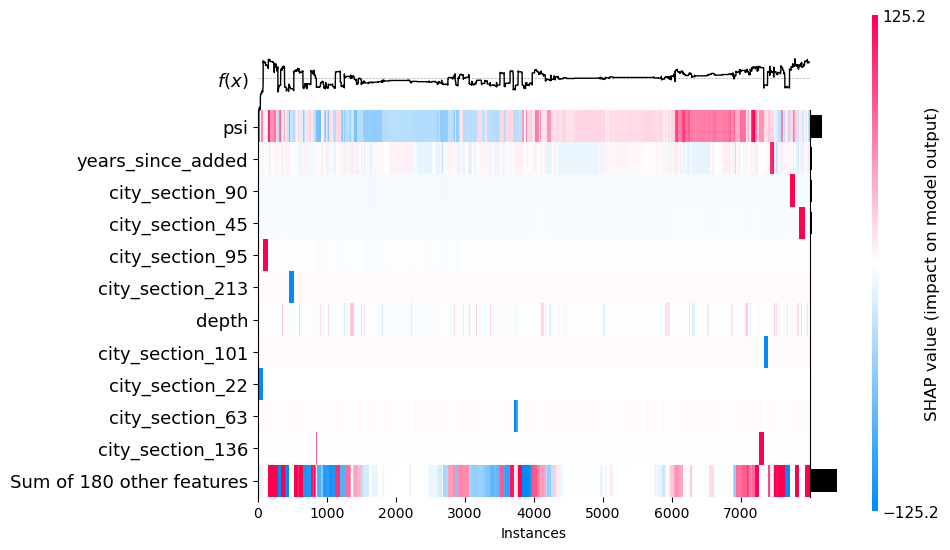

In [3]:
# Convert shap_values to an Explanation object before plotting
# included in a different cell because it is extremely computationally expensive
exp = shap.Explanation(values=shap_values, base_values=base_value, data=X_train, feature_names=full_feature_names)
shap.plots.heatmap(exp, max_display=12)